# Assignment 6: Face Recognition (Eigenfaces and Fisherfaces):
Name : Abreham Ararsa ID : GSR/9501/13

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
#functions
#euclidean distance for prediction, b/w new image and training set
def d(x,y):
    x = np.asarray(x).flatten()
    y = np.asarray (y).flatten()
    return np.sqrt (np.sum (np. power ((x-y) ,2)))

def predict (EigenV, mean , projections,X):
    toDistance = float("inf")
    toclass = -1
    projected = np.dot (X.reshape (1 , -1) - mean , EigenV)
    for i in range (len(projections)):
        dist = d( projections[i], projected)
        if dist < toDistance:
            toDistance = dist
            toclass = i
    return toclass


#principal component analysis
def componentsCount(eigenvalues, variance=.95):
    for i, j in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if j > variance:
            return i
def pca(X,Ncomponents):
    [instance,dimension] = X.shape
    meanx = 0 
    #calculate the mean and substruct from each image
    if ( Ncomponents <= 0) or ( Ncomponents > instance):
        Ncomponents = instance
        meanx = X.mean(axis =0)
        X = X - meanx
    #compute eigenvalues and eigen vectors from covarience matrix s
    if instance > dimension:
        s = np.dot(X.T,X) 
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(s)
    else :
        s = np.dot (X,X.T)
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(s)
        eigenvectors = np.dot(X.T, eigenvectors )
        for i in range (instance):
            eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    # sort eigenvectors in descending orders based on their eigenvalue
    sortedV = np.argsort (- eigenvalues )
    eigenvalues = eigenvalues [sortedV ]
    eigenvectors = eigenvectors [:, sortedV ]
    Ncomponents = componentsCount(eigenvalues)
    # select K principal components
    eigenvalues = eigenvalues [0: Ncomponents ].copy ()
    eigenvectors = eigenvectors [: ,0: Ncomponents ].copy ()
    #compute comulative eigenvectors
    #eigenvectors = np.cumsum(eigenvectors) / np.sum(eigenvectors)
    
    return [ eigenvalues , eigenvectors , meanx] 


def lda(X, y, nComponents=0):
    y = np.asarray(y)
    [instance,dimension] = X.shape
    c = np.unique(y)
    if (nComponents <= 0) or (nComponents>(len(c)-1)):
        nComponents = (len(c)-1)
    meanXE = X.mean(axis=0)
    Sw = np.zeros((dimension, dimension), dtype=np.float32)
    Sb = np.zeros((dimension, dimension), dtype=np.float32)
    for i in c:
        Xi = X[np.where(y==i)[0],:]
        meanClass = Xi.mean(axis=0)
        Sw = Sw + np.dot(((Xi-meanClass).T), (Xi-meanClass))
        Sb = Sb + instance * np.dot((meanClass - meanXE).T, (meanClass - meanXE))
        
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw)*Sb)
    idx = np.argsort(-eigenvalues.real)
    eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:,idx]
    eigenvalues = np.array(eigenvalues[0:nComponents].real, dtype=np.float32, copy=True)
    eigenvectors = np.array(eigenvectors[0:,0:nComponents].real, dtype=np.float32, copy=True)
    
    return [eigenvalues, eigenvectors]

def fisherfaces(X,y,Ncomponents):
    y = np.asarray(y)
    [n,d] = X.shape
    c = len(np.unique(y))
    [eigenvalues_pca, eigenvectors_pca, mu_pca] = pca(X,0)
    
    projected = np.dot (X - mu_pca , eigenvectors_pca)
    
    [eigenvalues_lda, eigenvectors_lda] = lda(projected, y, Ncomponents)
    eigenvectors = np.dot(eigenvectors_pca,eigenvectors_lda)
    return [eigenvalues_lda, eigenvectors, mu_pca]



#final Prediction both for Fisser and eigen faces
def image_prediction(alg,eigenvectors,mean,image_list,img_title,image_name_for_pred):        
    
    projections = []
    for i in image_list:

        projected = np.dot (i.reshape(1 , -1) - mean , eigenvectors)
        projections.append(projected)

    image = Image.open(os.path.join("testing_set", img_title))
    image = image.convert ("L")

    image = image.resize ([250,250] , Image.ANTIALIAS )
    test_image = np. asarray (image , dtype =np. uint8 )
    predicted = predict(eigenvectors, mean , projections, test_image)

    plot (title =alg, images =[test_image, image_list[predicted]], 
             titles = ["Unknown", "Prediction :{0}".format(image_name_for_pred[predicted])], )
#show prediction result
def plot(title, images, rows=1, cols=2, titles=[], colormap=cm.gray, ticks_visible=True, filename=None):
    fig = plt.figure()
    # main title
    fig.text(0.6, 0.9,title, horizontalalignment='center') 
    for i in range(len(images)):
        sub = fig.add_subplot(rows,cols,(i+1))
        plt.setp(sub.get_xticklabels(), visible=False)
        plt.setp(sub.get_yticklabels(), visible=False)
        if len(titles) == len(images):
            plt.title("#%s" % ( str(titles[i])))
        else:
            plt.title("#%d" % ((i+1)))
        plt.imshow(np.asarray(images[i]), cmap=colormap)
    plt.show()
        
#fisherface and eigenface 

def fisherPrediction(x,xi,y,image):
    
    [eigenvalues, eigenvectors, mean] = fisherfaces(xi,y,0)
    
    image_prediction("FisherFaces",eigenvectors,mean,x,image,y)
        
def eigenPrediction(x,xi,y,image):
    
    [eigenvalues, eigenvectors, mean] = pca(xi,0)
    
    image_prediction("eigenFaces",eigenvectors,mean,x,image,y)

In [4]:
#training image
subjects = [image for image in os.listdir('training_set')]
image_list = []
image_name_for_pred = []

#open triaining images and assign subject name

for name in subjects:
        current_image_path = os.path.join('training_set', name)
        image_names = [i for i in os.listdir(current_image_path) if not i.startswith('.')]
        
        for i in image_names:
            image = Image.open (os.path.join(current_image_path, i))
            image = image.convert ("L")
            # resize to 100*100
            image = image.resize ([250, 250] , Image.ANTIALIAS )
            image_list.append(np.asarray (image , dtype =np.uint8 ))
            image_name_for_pred.append(name)
           


In [5]:
# arrange the resized image data into 1 x rc data matrices
data_metrices = np.empty ((0 , image_list[0].size ),dtype =image_list[0].dtype)
for row in image_list:
    data_metrices = np.vstack(( data_metrices , np.asarray( row ).reshape(1 , -1)))

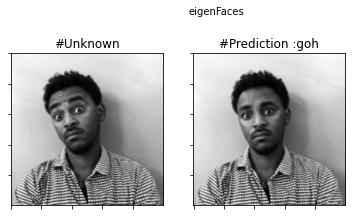

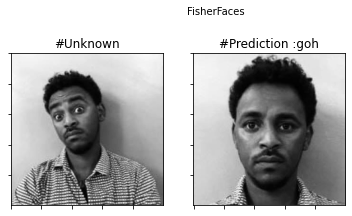

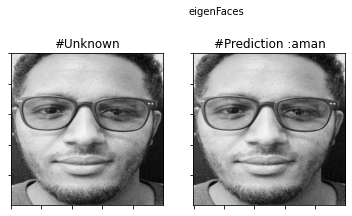

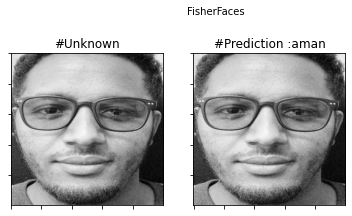

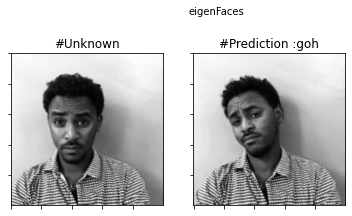

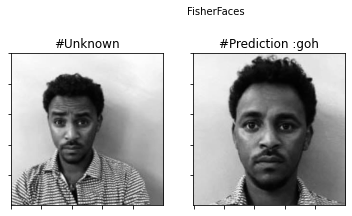

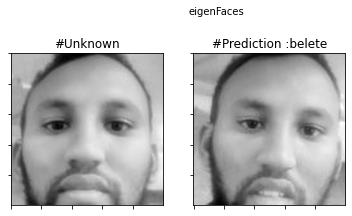

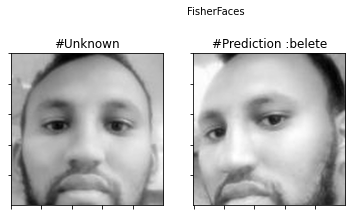

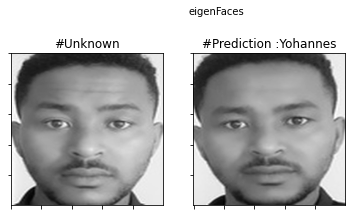

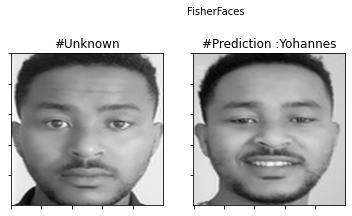

In [6]:
#testing image
subjects2 = [i for i in os.listdir('testing_set')]

for i in subjects2:
    eigenPrediction(image_list,data_metrices,image_name_for_pred,i)
    fisherPrediction(image_list,data_metrices,image_name_for_pred,i)